<a href="https://colab.research.google.com/github/shaaranii12/emotion-analyzer/blob/main/Emotion_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Preparation & Preprocessing

In [ ]:
#Installing the Transformers library
!pip install transformers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#from google.colab import files
#uploaded = files.upload()

Mounted at /content/drive


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

#Loading fine tuned model from Google Drive
Roberta = "/content/drive/MyDrive/Colab/Project1_Emotion_Analysis/finetuned_model"

#Roberta = "j-hartmann/emotion-english-distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(Roberta)
model = AutoModelForSequenceClassification.from_pretrained(Roberta)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

Initially, the pre-trained checkpoint j-hartmann/emotion-english-distilroberta-base
 was used as a baseline. After fine-tuning on the dataset, the model and tokenizer were saved to Google Drive and are now loaded directly to save training time and ensure consistent results.

In [ ]:
model.config.id2label

{0: 'anger',
 1: 'disgust',
 2: 'fear',
 3: 'joy',
 4: 'neutral',
 5: 'sadness',
 6: 'surprise'}

**So, now we know the model supports 7 emotions:**

0: anger 🤬

1: disgust 🤢

2: fear 😨

3: joy 😀

4: neutral 😐

5: sadness 😭

6: surprise 😲

### Dataset 1: Emotions by Nidula Elgiriyewithana (2023)

In [ ]:
import pandas as pd
#Loading of dataset
dataset1 = pd.read_csv('/content/drive/MyDrive/Colab/Project1_Emotion_Analysis/Emotions.csv', encoding='latin-1', on_bad_lines='skip', quoting=3)
dataset1.shape

model.safetensors:   0%|          | 0.00/329M [00:00<?, ?B/s]

(416809, 3)

In [ ]:
#Drop unnecessary columns
dataset1 = dataset1.drop(columns=["Unnamed: 0"])

In [ ]:
print(dataset1.head())

                                                text  label
0      i just feel really helpless and heavy hearted      4
1  ive enjoyed being able to slouch about relax a...      0
2  i gave up my internship with the dmrg and am f...      4
3                         i dont know i feel so lost      0
4  i am a kindergarten teacher and i am thoroughl...      4


Drop all data labeled love [2] because the model doesn’t support & it roughly corresponds to joy.

In [ ]:
dataset1 = dataset1[dataset1["label"] != 2].reset_index(drop=True)

In [ ]:
#Map the labels to their corresponding emotions.
label_mapping = {0: 'sadness', 1: 'joy', 3: 'anger', 4: 'fear', 5: 'surprise'}
dataset1['emotion'] = dataset1['label'].map(label_mapping)

In [ ]:
print(dataset1.head())

                                                text  label  emotion
0      i just feel really helpless and heavy hearted      4     fear
1  ive enjoyed being able to slouch about relax a...      0  sadness
2  i gave up my internship with the dmrg and am f...      4     fear
3                         i dont know i feel so lost      0  sadness
4  i am a kindergarten teacher and i am thoroughl...      4     fear


The dataset’s label IDs don’t match the model’s expected IDs, and each emotion maps differently. To avoid confusion we remap the labels to align with the model’s configuration.

In [ ]:
#Dataset to model label mapping
remap = {
    0: 5, #Sadness
    1: 3, #Joy
    3: 0, #Anger
    4: 2, #Fear
    5: 6  #Surprise
}

#Remapping the labels
dataset1["label"] = dataset1["label"].map(remap)
dataset1 = dataset1.reset_index(drop=True)

In [ ]:
print(dataset1.head())

                                                text  label  emotion
0      i just feel really helpless and heavy hearted      2     fear
1  ive enjoyed being able to slouch about relax a...      5  sadness
2  i gave up my internship with the dmrg and am f...      2     fear
3                         i dont know i feel so lost      5  sadness
4  i am a kindergarten teacher and i am thoroughl...      2     fear


### Dataset 2: Go Emotions by Shivam Bansal (2021)

In [ ]:
#Loading of dataset
dataset2 = pd.read_csv('/content/drive/MyDrive/Colab/Project1_Emotion_Analysis/GoEmotions.csv', encoding='latin-1', on_bad_lines='skip', quoting=3, low_memory=False)
dataset2.shape

(153466, 31)

In [ ]:
print(dataset2.head())

        id                                               text  \
0  eew5j0j                                    That game hurt.   
1  eemcysk  " >sexuality shouldnât be a grouping categor...   
2  eeibobj                                 Man I love reddit.   
3  ed5tx8y  That's crazy; I went to a super [RELIGION] hig...   
4  ef961hv                                that's adorable asf   

   example_very_unclear  admiration  amusement  anger  annoyance  approval  \
0                 False           0          0      0          0         0   
1                  True           0          0      0          0         0   
2                 False           0          0      0          0         0   
3                 False           0          1      0          0         0   
4                 False           0          1      0          0         0   

   caring  confusion  ...  love  nervousness  optimism  pride  realization  \
0       0          0  ...     0            0         0      0 

The original dataset has multiple columns indicating different emotions with 0/1 values. A single label column is created to summarize the dominant emotion for each text.

In [ ]:
#The emotions supported by the model, in it's label's order
main_emotions = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']

#Assigning label
def assign_label(row):
    for i, col in enumerate(main_emotions):
        if row[col] == 1:
            return i
    #Assign 7 for emotions other than the main 6
    return 7

dataset2['label'] = dataset2.apply(assign_label, axis=1)

In [ ]:
#mapping the labels (easier referencing)
label_map = {0: 'anger', 1: 'disgust', 2: 'fear', 3: 'joy', 4: 'neutral', 5: 'sadness', 6: 'surprise'}
dataset2['emotion'] = dataset2['label'].map(label_map)

In [ ]:
#Drop all rows that has the label 7 (other emotions)
dataset2 = dataset2[dataset2['label'] != 7].reset_index(drop=True)

#Drop all other unnecessary columns
dataset2 = dataset2[['text', 'label', 'emotion']]

In [ ]:
print(dataset2.head())

                                                text  label  emotion
0                                    That game hurt.      5  sadness
1                              BUT IT'S HER TURN! /s      4  neutral
2                                       That is odd.      1  disgust
3                                  Build a wall? /jk      4  neutral
4  This video doesn't even show the shoes he was ...      4  neutral


In [ ]:
import re

def clean_text(text):
    #Lowercase
    text = text.lower()

    #Remove placeholders like [NAME], [RELIGION], etc.
    text = re.sub(r'\[.*?\]', '', text)

    #Remove common social media tokens like /s, /jk, <3
    text = re.sub(r'/s|/jk|<3', '', text)

    #Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    #Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

#Apply to the dataframe
dataset2['text'] = dataset2['text'].apply(clean_text)

###Train-Test Split


Combining both dataset 1 and dataset 2

In [ ]:
data = pd.concat([dataset1, dataset2], ignore_index=True)
data.shape

(449339, 3)

In [ ]:
#Deduplicating data before splitting to avoid overlapping texts
data = data.drop_duplicates(subset=['text']).reset_index(drop=True)

The dataset has 450K+ rows, which is too large for quick fine-tuning. To speed things up, we limit it to 20,000 rows with an equal number of samples per label.

In [ ]:
#Perform stratified sampling to take an equal number of rows from each label.
n_per_class = 10000 // data["label"].nunique()
data = data.groupby("label", group_keys = False).apply(lambda x: x.sample(n = n_per_class, random_state = 42))

print(data["label"].value_counts())

label
0    1428
1    1428
2    1428
3    1428
4    1428
5    1428
6    1428
Name: count, dtype: int64


/tmp/ipython-input-37304074.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby("label", group_keys = False).apply(lambda x: x.sample(n = n_per_class, random_state = 42))


In [ ]:
#Get the number of unique emotions in the dataset
num_labels = data["label"].nunique()
print(f"Number of unique emotions: {num_labels}")

Number of unique emotions: 7


We split the dataset into training and test sets (80/20 - according to the
Pareto theory) so the model can learn from one portion and be fairly evaluated on unseen data.


In [ ]:
from sklearn.model_selection import train_test_split

#Stratified splitting of dataset
train_data, test_data = train_test_split(data, test_size = 0.2, stratify = data["label"], random_state = 42)

In [ ]:
print("Train data distribution:\n", train_data["label"].value_counts())
print("\nTest data distribution:\n", test_data["label"].value_counts())

Train data distribution:
 label
1    1143
0    1143
6    1142
3    1142
2    1142
5    1142
4    1142
Name: count, dtype: int64

Test data distribution:
 label
4    286
6    286
2    286
3    286
5    286
1    285
0    285
Name: count, dtype: int64


**Data leakage** is when information from the test set “leaks” into the training set, meaning the model accidentally sees data it shouldn’t during training. This makes the test accuracy look higher than reality because the model didn’t have to generalize, it just memorized.

In [ ]:
#Check to see if there's any overlapping texts (data leaks)
overlapping_texts = set(train_data["text"]).intersection(set(test_data["text"]))
print("Number of overlapping texts:", len(overlapping_texts))

#Drop overlaps directly from train_data and test_data to avoid data leakage
#train_data = train_data[~train_data["text"].isin(overlapping_texts)].reset_index(drop=True)
#test_data = test_data[~test_data["text"].isin(overlapping_texts)].reset_index(drop=True)

Number of overlapping texts: 0


## Model Fine-Tuning

In [ ]:
#Coverting pandas DataFrame into a Hugging Face Dataset
from datasets import Dataset, DatasetDict

train_hf = Dataset.from_pandas(train_data)
test_hf = Dataset.from_pandas(test_data)

data = DatasetDict({
    "train": train_hf,
    "test": test_hf
})

**Tokenization** turns text into numbers the model understands. This is important because models like RoBERTa cannot read raw text and only work with numerical tokens to learn patterns and make predictions.

In [ ]:
def tokenize(dataset):
    return tokenizer(dataset ["text"], padding=True, truncation=True, max_length=128)

data = data.map(tokenize, batched=True)
train_hf = train_hf.map(tokenize, batched=True)
test_hf = test_hf.map(tokenize, batched=True)

Map:   0%|          | 0/7996 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7996 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics_function(prediction):
    labels = prediction.label_ids
    predictions = prediction.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average = 'weighted')
    accuracy = accuracy_score(labels, predictions)
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
    }

In [ ]:
def model_init():
  return AutoModelForSequenceClassification.from_pretrained(Roberta)

In [ ]:
from transformers import Trainer, TrainingArguments

#Set the training arguments
training_arguments = TrainingArguments(
    output_dir = "./results",
    eval_strategy = "epoch",
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    num_train_epochs = 3,
    learning_rate = 2e-5,
    weight_decay = 0.01
)

#Construct the trainer
trainer = Trainer (
    model_init = model_init,
    args = training_arguments,
    train_dataset = data["train"],
    eval_dataset = data["test"],
    tokenizer = tokenizer,
    compute_metrics = compute_metrics_function
)

trainer.train()

/tmp/ipython-input-3446584045.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer (
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: 23005234 (23005234-university-of-malaya) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision
1,0.408500,0.340530,0.887000,0.887511,0.888615
2,0.280400,0.337330,0.894000,0.894472,0.895674
3,0.216500,0.358233,0.897000,0.897085,0.897774


TrainOutput(global_step=1500, training_loss=0.3017945098876953, metrics={'train_runtime': 325.2594, 'train_samples_per_second': 73.75, 'train_steps_per_second': 4.612, 'total_flos': 766425352521984.0, 'train_loss': 0.3017945098876953, 'epoch': 3.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.3582328259944916,
 'eval_accuracy': 0.897,
 'eval_f1': 0.8970845605507147,
 'eval_precision': 0.8977735876764974,
 'eval_runtime': 4.9545,
 'eval_samples_per_second': 403.673,
 'eval_steps_per_second': 25.23,
 'epoch': 3.0}

In [ ]:
# Save into Google Drive
model.save_pretrained("/content/drive/MyDrive/Colab/Project1_Emotion_Analysis/finetuned_model")
tokenizer.save_pretrained("/content/drive/MyDrive/Colab/Project1_Emotion_Analysis/finetuned_model")

('/content/drive/MyDrive/Colab/Project1_Emotion_Analysis/finetuned_model/tokenizer_config.json',
 '/content/drive/MyDrive/Colab/Project1_Emotion_Analysis/finetuned_model/special_tokens_map.json',
 '/content/drive/MyDrive/Colab/Project1_Emotion_Analysis/finetuned_model/vocab.json',
 '/content/drive/MyDrive/Colab/Project1_Emotion_Analysis/finetuned_model/merges.txt',
 '/content/drive/MyDrive/Colab/Project1_Emotion_Analysis/finetuned_model/added_tokens.json',
 '/content/drive/MyDrive/Colab/Project1_Emotion_Analysis/finetuned_model/tokenizer.json')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

#Get the model predictions on the test set
results = trainer.predict(data["test"])

#Extract predicted and true labels
predicted = results.predictions.argmax(-1) #argmax pick class with highest probability
labels = results.label_ids

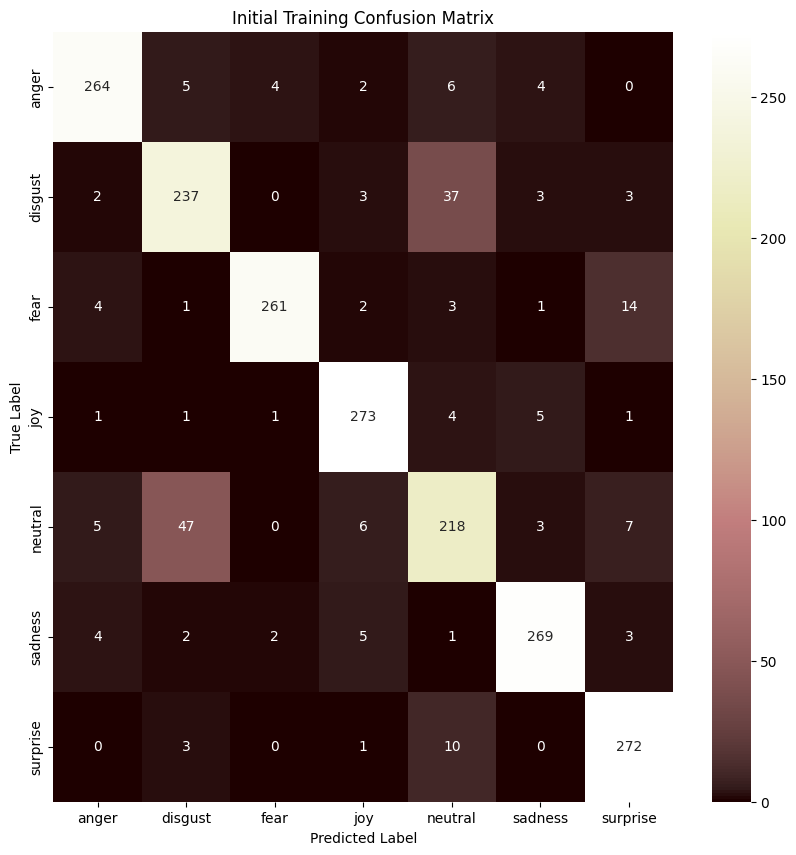

[[264   5   4   2   6   4   0]
 [  2 237   0   3  37   3   3]
 [  4   1 261   2   3   1  14]
 [  1   1   1 273   4   5   1]
 [  5  47   0   6 218   3   7]
 [  4   2   2   5   1 269   3]
 [  0   3   0   1  10   0 272]]


In [ ]:
# Define label names for better clarity in the confusion matrix
label_names = ["anger", "disgust", "fear", "joy", "neutral", "sadness", "surprise"]

# Generate the confusion matrix
cmx = confusion_matrix(labels, predicted)

# Plot out the confusion matrix
plt.figure(figsize = (10, 10))
sns.heatmap(cmx, annot = True, fmt = 'd', xticklabels = label_names, yticklabels = label_names, cmap = "pink")

#Add labels
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Initial Training Confusion Matrix')
plt.show()

print(cmx)

## Deployment to Gradio

The fine-tuned emotion analysis model was deployed on Hugging Face by uploading it to the Model Hub and linking it with a Space.

In [ ]:
!pip install gradio

In [ ]:
!pip install -U huggingface_hub

In [ ]:
#Import Hugging Face Hub functions for authentication and uploading
from huggingface_hub import login, create_repo, upload_folder
from transformers import AutoModelForSequenceClassification, AutoTokenizer

In [ ]:
#Log in to Hugging Face Hub and authenticate with tokens
login()

In [ ]:
#Define the repository ID
repo_id = "Shaaranii12/emotion-analysis-model"

#Create a new repository on Hugging Face Hub
create_repo(repo_id=repo_id, repo_type="model", private=False, exist_ok=True)
print("Repo created at:", "https://huggingface.co/" + repo_id)

Repo created at: https://huggingface.co/Shaaranii12/emotion-analysis-model


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


1.   repo_type="model" means this is a model repo, not a dataset or Space
2.   private=False makes it public so your Space can access it
3. exist_ok=True means create repo if it doesn't exist, otherwise do nothing to throw off error warning

In [ ]:
#uploading the trained fine tuned model
local_model_path = "/content/drive/MyDrive/Colab/Project1_Emotion_Analysis/finetuned_model"

upload_folder(
    repo_id="Shaaranii12/emotion-analysis-model",  # your repo
    folder_path=local_model_path,
    path_in_repo=".",   # upload into root of repo
    commit_message="Upload fine-tuned RoBERTa emotion model"
)

#https://huggingface.co/spaces/Shaaranii12/emotion-analyzer

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...s/finetuned_model/model.safetensors:   8%|7         | 25.1MB /  329MB            

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/Shaaranii12/emotion-analysis-model/commit/cb752e6026b50cc02a1518cd7fe2b91bdffb7093', commit_message='Upload fine-tuned RoBERTa emotion model', commit_description='', oid='cb752e6026b50cc02a1518cd7fe2b91bdffb7093', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Shaaranii12/emotion-analysis-model', endpoint='https://huggingface.co', repo_type='model', repo_id='Shaaranii12/emotion-analysis-model'), pr_revision=None, pr_num=None)

The model was successfully uploaded and deployed on Hugging Face Spaces, creating a simple web app where users can input text and see the predicted emotion.

Click the link to explore the app: [Emotions Analyzer](https://huggingface.co/spaces/Shaaranii12/emotion-analyzer)